## Training for Chatbot Agent

In [767]:

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import List, Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import InjectedState
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display, Markdown

import requests
import os
from supabase import create_client, Client
from dotenv import load_dotenv
from typing import Optional
from pprint import pprint
from datetime import datetime


In [768]:
load_dotenv()

True

In [769]:
MENU_BACKEND_URL = os.getenv("MENU_BACKEND_URL")

In [770]:
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
# response = model.invoke("Hello World!!")
# print(response)

### Chatbot Agent for Food Ordering

The objectives of this agent are:
1. To help customers browse the food menu. Customers can say - "I want a coffee" and chatbot should respond with coffee options and help customer choose a coffee.
2. Customers can add item to their cart - 
3. Customers can place order 
4. Customers can check their placed order with orderID

### Initial State for the Agent
Define the State for our Graph workflow

In [771]:
# Cart Items & Cart

class ItemVariation(BaseModel):
    id: str = Field(description="Unique id of this variation for the item")
    name: str = Field(description="Name of this variation")
    price: str = Field(description="Price of this variation of the item")

class CartItemUnit(BaseModel):
    key: str = Field(
        description="Unique key for the item in the cart to match an item being added")
    quantity: int = Field(description="Quantity of this specific variation/customization")
    base_price: float = Field(description="Base price of the item (cannot be null)")
    variation: Optional[ItemVariation] = Field(default=None, description="Variation of the item if available")

class CartItem(BaseModel):
    item_id: str = Field(description="unique UUID for this item")
    title: str = Field(description="Name of the item")
    units: List[CartItemUnit]

class Cart(BaseModel):
    items: List[CartItem] = Field(default_factory=List)
    

In [772]:
class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    # its a list but can be a list of dict in real world to capture more details about the order
    # its essentialy the cart
    cart: Optional[Cart]
    
    orderId: Optional[str]

    # Flag indicating that the order is placed and completed.
    finished: bool

### Prompt

In [773]:
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
SYSTEM_INSTRUCTION = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a helpful chatbot named Annapurna based in India, an interactive food ordering system for Zaaika India. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "Use the get_menu tool to fetch the lastest menu items available."
    "Always greet the customer with Namaste and personalized messages, keep the experience delightful for them"
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "User can ask to add items in the cart. Add items to the customer's cart with add_cart, and reset the cart with clear_cart. "
    "IMPORTANT: When a customer wants to add or remove multiple different items, add or remove them ONE AT A TIME using separate add_cart or remove_from_cart calls."
    "To see the contents of the cart so far, call get_cart (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with available variations of items in the MENU before adding them to the order. "
    "If you are unsure an item matches those on the MENU, ask a question to clarify or redirect. Customers can also ask for some item "
    "that is related to the items in the menu, in such cases show them the items in the MENU and tell them that this is similar to what they are asking"
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user, show them order details and "
    "say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the Bella Italia cafe. Type `q` to quit. How may I serve you today?"

### Tools

NOTE 
- Earlier it was not possible to update Agent State from inside a Tool in LangGraph. But with latest updates, it has been allowed now to update the State directly from a tool. Check this [official doc](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/#update-state)

In [774]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [775]:
@tool
def get_menu():
    """Provide the latest up-to-date menu."""
    
    # once you fetch the menu from backend service
    # try to convert it into LLM readable format (if possible - check this case)
    
    response = requests.get(
        MENU_BACKEND_URL + "/v1/storefront/menu?subdomain=zaaika-india")
    
    if response.status_code == 200:
        # pprint(response.json())
        menu = response.json()
        items = menu['items']
        # pprint(items)
        return items
    else:
        print("Error fetching the menu")

In [776]:
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.types import Command
from langchain_core.messages import ToolMessage


@tool
def add_cart(item_id: str, title: str, new_item: CartItemUnit, tool_call_id: Annotated[str, InjectedToolCallId], state: Annotated[OrderState, InjectedState]):
    """
    Adds an item to the cart
    
    Args:
    item_id : Unique UUID for the item
    title: Title of the item
    new_item: Cart item details with base_price, quantity, and variation (only if the item has variants like Full/Half)
    """

    # Handle variation ID safely
    variation_id = "no_variant"
    valid_variation = None

    # Only process variation if it exists and has valid data
    if (new_item.variation and
        hasattr(new_item.variation, 'id') and
        new_item.variation.id and
            new_item.variation.id.strip()):
        variation_id = new_item.variation.id
        valid_variation = new_item.variation


    item_key = f"{item_id}|{variation_id}"

    # Create a proper CartItemUnit with the key
    updated_unit = CartItemUnit(
        key=item_key,
        quantity=new_item.quantity,
        base_price=new_item.base_price,
        variation=valid_variation
    )
    
    print(updated_unit)

    # Get current cart
    current_cart = state["cart"]
    if current_cart is None:
        # If cart is None, create new cart with this item
        new_cart_item = CartItem(
            item_id=item_id,
            title=title,
            units=[updated_unit]
        )
        updated_cart = Cart(items=[new_cart_item])
    else:
        # Check if item already exists in cart
        item_found = False
        updated_items = []

        for existing_item in current_cart.items:
            if existing_item.item_id == item_id:
                # Item exists, check if this specific variant exists
                unit_found = False
                updated_units = []

                for existing_unit in existing_item.units:
                    if existing_unit.key == item_key:
                        # Same variant exists, increment quantity
                        updated_units.append(CartItemUnit(
                            key=existing_unit.key,
                            quantity=existing_unit.quantity + new_item.quantity,
                            base_price=existing_unit.base_price,
                            variation=existing_unit.variation
                        ))
                        unit_found = True
                    else:
                        updated_units.append(existing_unit)

                if not unit_found:
                    # New variant of existing item
                    updated_units.append(updated_unit)

                updated_items.append(CartItem(
                    item_id=existing_item.item_id,
                    title=existing_item.title,
                    units=updated_units
                ))
                item_found = True
            else:
                updated_items.append(existing_item)

        if not item_found:
            # Completely new item
            new_cart_item = CartItem(
                item_id=item_id,
                title=title,
                units=[updated_unit]
            )
            updated_items.append(new_cart_item)

        updated_cart = Cart(items=updated_items)

    print("Printing cart")
    pprint(updated_cart.model_dump())

    return Command(update={
        "cart": updated_cart,
        "messages": [
            ToolMessage(
                f"Added {title} to cart", tool_call_id=tool_call_id)
        ]
    })

In [777]:
@tool
def remove_from_cart(item_id: str, title: str, new_item: CartItemUnit, tool_call_id: Annotated[str, InjectedToolCallId], state: Annotated[OrderState, InjectedState]):
    """
    Removes an item from the cart
    
    Args:
    item_id : Unique UUID for the item
    title: Title of the item
    new_item: A dict containing base_price and quantity of the item to remove
    """

    # Handle variation ID safely
    variation_id = "no_variant"
    if new_item.variation and hasattr(new_item.variation, 'id'):
        variation_id = new_item.variation.id

    item_key = f"{item_id}|{variation_id}"

    # Get current cart
    current_cart = state["cart"]
    if current_cart is None or not current_cart.items:
        return Command(update={
            "messages": [
                ToolMessage(
                    f"Cart is empty. Cannot remove {title}.", tool_call_id=tool_call_id)
            ]
        })

    # Find and remove the item
    updated_items = []
    item_found = False
    removal_message = f"Item {title} not found in cart."

    for existing_item in current_cart.items:
        if existing_item.item_id == item_id:
            # Item exists, check if this specific variant exists
            unit_found = False
            updated_units = []

            for existing_unit in existing_item.units:
                if existing_unit.key == item_key:
                    # Found the variant to remove
                    unit_found = True
                    if existing_unit.quantity > new_item.quantity:
                        # Reduce quantity
                        updated_units.append(CartItemUnit(
                            key=existing_unit.key,
                            quantity=existing_unit.quantity - new_item.quantity,
                            base_price=existing_unit.base_price,
                            variation=existing_unit.variation
                        ))
                        removal_message = f"Reduced {title} quantity by {new_item.quantity}"
                    elif existing_unit.quantity == new_item.quantity:
                        # Remove this variant completely (don't add to updated_units)
                        removal_message = f"Removed {title} from cart"
                    else:
                        # Trying to remove more than available
                        updated_units.append(existing_unit)
                        removal_message = f"Cannot remove {new_item.quantity} {title}. Only {existing_unit.quantity} available."
                else:
                    # Keep other variants
                    updated_units.append(existing_unit)

            if unit_found:
                item_found = True
                if updated_units:
                    # Still has other variants, keep the item
                    updated_items.append(CartItem(
                        item_id=existing_item.item_id,
                        title=existing_item.title,
                        units=updated_units
                    ))
                # If no units left, item is completely removed (don't add to updated_items)
            else:
                # Variant not found, keep original item
                updated_items.append(existing_item)
                removal_message = f"Variant of {title} not found in cart."
        else:
            # Different item, keep it
            updated_items.append(existing_item)

    if not item_found:
        # Item ID not found at all
        updated_cart = current_cart
    else:
        # Update cart with remaining items
        updated_cart = Cart(items=updated_items)

    print("Cart after removal:")
    pprint(updated_cart.model_dump())

    return Command(update={
        "cart": updated_cart,
        "messages": [
            ToolMessage(removal_message, tool_call_id=tool_call_id)
        ]
    })

In [778]:
@tool
def clear_cart():
    """Clears the entire cart and removes all the present items in the cart"""
    return

In [779]:
@tool
def confirm_order(state: Annotated[OrderState, InjectedState]):
    """Provide the lastest items in the cart for user to confirm"""
    return state['cart']

In [780]:
@tool
def get_cart(state: Annotated[OrderState, InjectedState]):
    """Provide the lastest items in the cart"""
    # print("Input State", state)
    return state['cart']
    

In [781]:
@tool
def place_order(tool_call_id: Annotated[str, InjectedToolCallId], state: Annotated[OrderState, InjectedState]):
    """Place the order and complete the ordering process"""

    current_cart = state['cart']

    # Check if cart is empty
    if current_cart is None or not current_cart.items:
        return Command(update={
            "messages": [
                ToolMessage(
                    "Cannot place order. Cart is empty. Please add items to your cart first.",
                    tool_call_id=tool_call_id
                )
            ]
        })

    # TODO: Call the backend API to place the order which returns an orderId for the customer
    # For now, we'll simulate with a mock order ID
    import uuid
    mock_order_id = str(uuid.uuid4())[:8]  # Generate a short mock order ID

    # Calculate total items for confirmation message
    total_items = sum(sum(unit.quantity for unit in item.units)
                      for item in current_cart.items)

    # Clear the cart after placing order
    empty_cart = Cart(items=[])

    # Update state: clear cart, set orderId, and mark as finished
    return Command(update={
        "cart": empty_cart,
        "orderId": mock_order_id,
        "finished": True,
        "messages": [
            ToolMessage(
                f"Order placed successfully! Your order ID is {mock_order_id}. "
                f"Total items: {total_items}. Thank you for your order!",
                tool_call_id=tool_call_id
            )
        ]
    })

### Final tools

In [ ]:

tools = [get_menu, get_cart, add_cart, remove_from_cart, place_order, confirm_order]

# we use prebuilt ToolNode from LangGraph
tool_node = ToolNode(tools)

# bind these tools to the LLM
model_with_tools = model.bind_tools(tools)

### Nodes

In [783]:
from langchain_core.messages.ai import AIMessage


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the model.
        new_output = model_with_tools.invoke([SYSTEM_INSTRUCTION] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    # Initialize cart as Cart model if not present or if it's an empty list
    current_cart = state.get("cart")
    if current_cart is None or current_cart == []:
        current_cart = Cart(items=[])
        
    return {
        "messages": state.get("messages", []) + [new_output],
        "cart": current_cart,
        "orderId": state.get("orderId"),
        "finished": state.get("finished", False)
    }

### Build the graph

In [784]:
chatbot_graph_builder = StateGraph(OrderState)

# node names
NODE_CHATBOT = "chatbot"
NODE_TOOLS = "tools"

# nodes
chatbot_graph_builder.add_node(NODE_CHATBOT, chatbot)
chatbot_graph_builder.add_node(NODE_TOOLS, tool_node)

# edges
chatbot_graph_builder.add_edge(START, NODE_CHATBOT)
# tools will always return back to chatbot
chatbot_graph_builder.add_edge(NODE_TOOLS, NODE_CHATBOT)
chatbot_graph_builder.add_conditional_edges(NODE_CHATBOT, tools_condition)

### Create Memory checkpointer
This is crucial for building multi turn chat conversations.

In [785]:
memory = MemorySaver()

### Compile the Graph

In [786]:
chatbot_graph = chatbot_graph_builder.compile(checkpointer=memory) # compile the graph with memory checkpointer created above

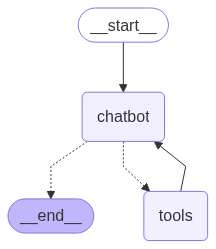

In [787]:
from IPython.display import Image, display

try:
    display(Image(chatbot_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Interact with the Chatbot
1. check how to stream chat back to the UI client

In [788]:
def chatbot_streaming(session_id: str, user_message: str):
    # initialize the config
    if not session_id:
        raise ValueError("session_id is missing.")
    config = {"configurable": {"thread_id": session_id}}
    
    events = chatbot_graph.stream(
        {"messages": [{"role": "user", "content": user_message}]},
        config,
        stream_mode="values",
        # stream_mode="messages"
    )


    for event in events:
        last_message = event['messages'][-1]
        if type(last_message).__name__ == 'ToolMessage':
            if last_message.status == "error":
                print(last_message.content)
            else:
                print(f"{type(last_message).__name__}: {last_message.content[:30]}...")
        else:
            print(f"{type(last_message).__name__}: {last_message.content}")

        if last_message.type == "ai":
            print(f"Tools called: ", last_message.tool_calls)
        
            

    

In [802]:
session_id = "1"

user_message = "Hi, I am Shashank."
# user_message = "Hi, do you remember my name?"
# user_message = "What menu items do your cafe have?"
# user_message = "Tell me something about Paneer Butter Masala"
# user_message = "Can you check if I have some items in my order?"
# user_message = "What's your name?"
user_message = "I want to order Ras Malai"
user_message = "Yes add Ras Malai to cart"
# user_message = "I want a black coffee"
# user_message = "What else you have in the main course?"
# user_message = "I want Veg Kolhapuri."
# user_message = "Full"
# user_message = "Can you show me my cart."
# user_message = "I want 2 more ras malais."
# user_message="Add one paneer butter masala"
# user_message="Can you check whats the total amount"
# user_message="I want to remove paneer butter masala"
user_message="I want to add veg kolhapuri"
user_message="2 Half"
# user_message="3 Half Veg Kolhapuri and 1 Ras Malai"
# user_message="Yes"
# user_message="Remove veg kolhapuri"
# user_message="Half"
# user_message="Remove coffee from cart" 
user_message="Place this order"
user_message="Yes i am fine"
# user_message="Do we have any cottage cheese?"

# user_message="Add 1 Paneer Butter Masala and 2 Ras Malais"
chatbot_streaming(session_id=session_id, user_message=user_message)

HumanMessage: Yes i am fine
AIMessage: 
Tools called:  [{'name': 'place_order', 'args': {}, 'id': '3220fb2a-9996-4153-a10b-1f05cdc5bbb5', 'type': 'tool_call'}]
ToolMessage: Order placed successfully! You...
AIMessage: Thank you for your order! Your order has been placed successfully. Your order ID is b8384a11, and you have a total of 6 items.

Goodbye and hope to serve you again soon!
Tools called:  []


In [790]:
# session_id = 2

# while True:
#     try:
#         user_input = input("User: ")
#         # to allow quit
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break
#         chatbot_streaming(session_id, user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         chatbot_streaming(session_id, user_input)
#         break

### Observations
1. the chatbot consistently asks the user what would they like to order? no off topic discussion and drive the chat back to the agenda - ordering food!
2. I developed the same chatbot using DialogFlow but the major difference is that it was more like a chatbot, robotic tone. This one with LLM is more creative, more humane like. 
3. The good thing is we do not need extenstive training here, eg. if an items comes in different variants full and half, if the user asks to add this in order, LLM asks a follow up question to know the variant. This is cool actually.
```sh
HumanMessage: I want to add veg kolhapuri
AIMessage: Do you want a Full or Half order of Veg Kolhapuri?
Tools called:  []
```

```sh
HumanMessage: Remove veg kolhapuri
AIMessage: Which Veg Kolhapuri would you like to remove? The Full, the Half, or both?
Tools called:  []
```

```sh
HumanMessage: Remove coffee from cart
AIMessage: I don't see any coffee in your cart currently. Would you like to add coffee, or did you mean to remove something else?
Tools called:  []
```

```sh
HumanMessage: Place this order
AIMessage: Okay, so I have:
- 1 Ras Malai
- 2 Veg Kolhapuri (Full)

Is that correct?
Tools called:  []
```

```sh
HumanMessage: Do we have any cottage cheese?
AIMessage: Namaste! Yes, we do have dishes with cottage cheese, which is known as Paneer in India. We have:

*   **Paneer Butter Masala**: A delicious creamy and full of butter paneer dish for ₹320.
*   **Ras Malai**: A rich and creamy Indian dessert featuring soft paneer dumplings for ₹90.
*   **Veg Nargisi Kofta**: Vegetable and paneer dumplings served in a rich and creamy tomato-based gravy. It's available in Full for ₹340 and Half for ₹190.

Would you like to add any of these to your order?
Tools called:  []
```

4. Also, it handles lot of routine methods like getting the total amount from cart, which otherwise require a function to write.

```sh
HumanMessage: I want to remove paneer butter masala
AIMessage: No problem. I have not implemented the remove item functionality yet! Keep reading the instructions to see how to implement this.
Tools called:  []
```

In [791]:
def get_current_state(session_id: str):
    config = {"configurable": {"thread_id": session_id}}
    snapshot = chatbot_graph.get_state(config)
    return snapshot

In [799]:
current_state = get_current_state(session_id)
# pprint(current_state.values)

In [800]:
cart = current_state.values['cart']
cart.model_dump()

{'items': [{'item_id': '0e2c5969-c73e-440a-9444-557b2fab9206',
   'title': 'Ras Malai',
   'units': [{'key': '0e2c5969-c73e-440a-9444-557b2fab9206|no_variant',
     'quantity': 3,
     'base_price': 90.0,
     'variation': None}]},
  {'item_id': 'f7e1be59-a4f6-4497-854c-d21fbba8bd83',
   'title': 'Veg Kolhapuri',
   'units': [{'key': 'f7e1be59-a4f6-4497-854c-d21fbba8bd83|a7eb2f4f-ad08-458f-87a1-b92cb300b83c',
     'quantity': 2,
     'base_price': 160.0,
     'variation': {'id': 'a7eb2f4f-ad08-458f-87a1-b92cb300b83c',
      'name': 'Half',
      'price': '160'}}]},
  {'item_id': 'd352577d-5eb1-40db-9a43-102325de1eb8',
   'title': 'Paneer Butter Masala',
   'units': [{'key': 'd352577d-5eb1-40db-9a43-102325de1eb8|no_variant',
     'quantity': 1,
     'base_price': 320.0,
     'variation': None}]}]}